## Import necessary packages:

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

## Import data and assign feature name to each column:

In [11]:
columns = []
with open('kddcup.names') as f:
    next(f)
    for line in f:
        feature = line.split(':')[0]
        columns.append(feature)
columns.append('label')

In [12]:
train_data = pd.read_csv('kddcup.data', header=None)
train_data.columns = columns
train_data['label'] = train_data['label'].apply(lambda x: x.replace('.', ''))

test_data = pd.read_csv('corrected', header=None)
test_data.columns = columns
test_data['label'] = test_data['label'].apply(lambda x: x.replace('.', ''))

In [13]:
boundary = train_data.shape[0]
whole_data = pd.concat([train_data, test_data], axis=0)

## One-hot encoding:

In [15]:
categorical = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
whole_data_categorical = whole_data[categorical].copy()
whole_data.drop(columns=categorical, inplace=True)

le = preprocessing.LabelEncoder()
whole_data_categorical_T = whole_data_categorical.apply(le.fit_transform)

enc = preprocessing.OneHotEncoder()
whole_data_categorical_T = enc.fit_transform(whole_data_categorical_T).toarray()

num_features = whole_data_categorical_T.shape[1]
whole_data_categorical_T = pd.DataFrame(data=whole_data_categorical_T, index=whole_data.index, columns=[str(i) for i in range(num_features)])

whole_data = pd.concat([whole_data_categorical_T, whole_data], axis=1)

/anaconda3/envs/dme/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## Split data into training and test set:

In [22]:
train_data = whole_data.iloc[:boundary]
test_data = whole_data.iloc[boundary:]

X_train, y_train = train_data.drop(columns='label'), train_data['label']
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=0)
X_test, y_test = test_data.drop(columns='label'), test_data['label']

## Store preprocessed data for later usage:

In [23]:
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)

np.save("X_valid.npy", X_valid)
np.save("y_valid.npy", y_valid)

np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

## Load preprocessed data back:

In [3]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")

X_valid = np.load("X_valid.npy")
y_valid = np.load("y_valid.npy")

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

## Standardize feature vectors using RobustScaler:

In [4]:
rscaler = preprocessing.RobustScaler().fit(X_train)
X_train, X_valid, X_test = rscaler.transform(X_train), rscaler.transform(X_valid), rscaler.transform(X_test)

## Use linear PCA to perform dimensionality reduction:
**Warning**: linear PCA seems to be **not** working on this dataset.

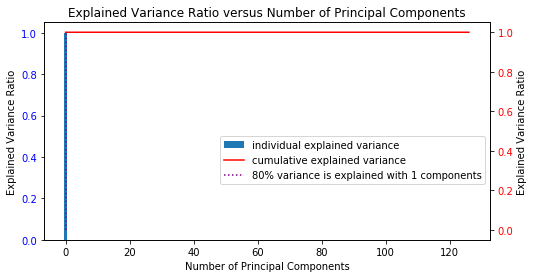

In [18]:
pca = PCA(n_components=X_train.shape[1], svd_solver='full')
pca.fit(X_train)

fig, ax1 = plt.subplots(figsize=(8, 4))
graph1 = ax1.bar(np.arange(X_train.shape[1]), pca.explained_variance_ratio_, label='individual explained variance')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Explained Variance Ratio')

ax2 = ax1.twinx()
graph2 = ax2.plot(np.cumsum(pca.explained_variance_ratio_), c='red', label='cumulative explained variance')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('Explained Variance Ratio')

index = np.nonzero(np.cumsum(pca.explained_variance_ratio_) >= 0.8)[0][0]
graph3 = ax2.vlines(index, 0, 1, color='purple', linestyles="dotted", label='80% variance is explained with {} components'.format(index+1))

graphs = [graph1, graph2[0], graph3]
labels = [g.get_label() for g in graphs]
ax1.legend(graphs, labels, bbox_to_anchor=(1, 0.5))

plt.title('Explained Variance Ratio versus Number of Principal Components')
plt.show()

## Linear Regression for normal and non-normal binary classification:

In [38]:
# Binarize labels into normal and non-normal:
y_train_binarized = (y_train == 'normal').astype(int)
y_valid_binarized = (y_valid == 'normal').astype(int)
y_test_binarized = (y_test == 'normal').astype(int)

# Stratified holdout validation:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

In [ ]:
parameters = {
    #'C': np.logspace(-5, 5, 30)
    'C': [1]
}

# L1 regularization mimics the feature selection process due to its sparsity
gs_lgr = GridSearchCV(LogisticRegression(penalty='l1', class_weight='balanced', solver='saga'), parameters, cv=sss)
gs_lgr.fit(X_train, y_train_binarized)

lgr = gs_lgr.best_estimator_
y_pred_valid_binarized = lgr.predict_proba(X_valid)
roc_auc = roc_auc_score(y_valid_binarized, y_pred_valid_binarized)

print ("The best ROC_AUC for Logistic Regression on validation set is {:.4f}".format(roc_auc))
display(gs_lgr.best_params_)

## Softmax Regression for attack type multiclass classification:

In [36]:
# Exclude normal instances from dataset:
y_train_no_normal_idx = (y_train != 'normal')
X_train_no_normal, y_train_no_normal = X_train[y_train_no_normal_idx], y_train[y_train_no_normal_idx]

y_valid_no_normal_idx = (y_valid != 'normal')
X_valid_no_normal, y_valid_no_normal = X_valid[y_valid_no_normal_idx], y_valid[y_valid_no_normal_idx]

y_test_no_normal_idx = (y_test != 'normal')
X_test_no_normal, y_test_no_normal = X_test[y_test_no_normal_idx], y_test[y_test_no_normal_idx]

In [ ]:
parameters = {
    #'C': np.logspace(-5, 5, 30)
    'C': [1]
}

# L1 regularization mimics the feature selection process due to its sparsity
gs_smr = GridSearchCV(LogisticRegression(multi_class='multinomial', penalty='l1', class_weight='balanced', solver='saga'), parameters, cv=sss)
gs_smr.fit(X_train_no_normal, y_train_no_normal)

smr = gs_smr.best_estimator_
y_pred_valid_no_normal = smr.predict_proba(X_valid_no_normal)

# Multiclass average ROC_AUC score:
avg_roc_auc = 0
for i, attack in enumerate(smr.classes_):
    y_valid_attack = (y_valid_no_normal == attack).astype(int)
    y_pred_valid_attack = y_pred_valid_no_normal[:,i]
    avg_roc_auc += roc_auc_score(y_valid_attack, y_pred_valid_attack)
    
avg_roc_auc /= len(smr.classes_)

print ("The best average ROC_AUC for Softmax Regression on validation set is {:.4f}".format(avg_roc_auc))
display(gs_smr.best_params_)